In [1]:
import malariagen_data
import numpy as np
import dask
import dask.array as da
from dask.diagnostics.progress import ProgressBar
# silence some warnings
dask.config.set(**{'array.slicing.split_large_chunks': False})
import allel
import pandas as pd
import matplotlib.pyplot as plt
from re import sub
import seaborn as sns

/home/elucas/miniconda3/envs/mozzie37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data access from Google Cloud is set up with the following code. 

In [2]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)

In [3]:
df_sample_sets = ag3.sample_sets(release="v3.2")
df_sample_sets

sample_set  sample_count release
0    1177-VO-ML-LEHMANN-VMF00015            23    v3.2
1  1237-VO-BJ-DJOGBENOU-VMF00050            90    v3.2
2  1237-VO-BJ-DJOGBENOU-VMF00067           142    v3.2
3     1244-VO-GH-YAWSON-VMF00051           666    v3.2
4   1245-VO-CI-CONSTANT-VMF00054            38    v3.2
5  1253-VO-TG-DJOGBENOU-VMF00052           179    v3.2

In [4]:
meta = ag3.sample_metadata(
    sample_sets=["1244-VO-GH-YAWSON-VMF00051"]
)
meta.head()

sample_id partner_sample_id             contributor country  \
0  VBS19051-5563STDY7800136           WA-0001  Alexander Egyir-Yawson   Ghana   
1  VBS19052-5563STDY7800137           WA-0002  Alexander Egyir-Yawson   Ghana   
2  VBS19053-5563STDY7800138           WA-0003  Alexander Egyir-Yawson   Ghana   
3  VBS19055-5563STDY7800140           WA-0005  Alexander Egyir-Yawson   Ghana   
4  VBS19056-5563STDY7800141           WA-0006  Alexander Egyir-Yawson   Ghana   

       location  year  month  latitude  longitude sex_call  \
0  Madina_North  2017     11     5.683     -0.166        F   
1  Madina_North  2017     11     5.683     -0.166        F   
2  Madina_North  2017     11     5.683     -0.166        F   
3  Madina_North  2017     11     5.683     -0.166        F   
4  Madina_North  2017     11     5.683     -0.166        F   

                   sample_set release  aim_fraction_colu  aim_fraction_arab  \
0  1244-VO-GH-YAWSON-VMF00051    v3.2              0.034              0.002   
1  1244-VO-GH-YAWSON-VMF00051    v3.2              0.023              0.002   
2  1244-VO-GH-YAWSON-VMF00051    v3.2              0.022              0.002   
3  1244-VO-GH-YAWSON-VMF00051    v3.2              0.025              0.002   
4  1244-VO-GH-YAWSON-VMF00051    v3.2              0.028              0.002   

  species_gambcolu_arabiensis species_gambiae_coluzzii  species  
0                   gamb_colu                  gambiae  gambiae  
1                   gamb_colu                  gambiae  gambiae  
2                   gamb_colu                  gambiae  gambiae  
3                   gamb_colu                  gambiae  gambiae  
4                   gamb_colu                  gambiae  gambiae

In [5]:
meta.groupby(['country', 'location', 'year', 'species']).size()

country  location      year  species                      
Ghana    Korle-Bu      2018  coluzzii                         264
                             intermediate_gambiae_coluzzii      4
         Madina_North  2017  gambiae                          200
         Obuasi        2017  gambiae                          198
dtype: int64

In [6]:
sample_names = np.array(
    [sub('-.*', '', x) for x in meta.sample_id]
)
sample_names

array(['VBS19051', 'VBS19052', 'VBS19053', 'VBS19055', 'VBS19056',
       'VBS19057', 'VBS19058', 'VBS19059', 'VBS19060', 'VBS19062',
       'VBS19063', 'VBS19064', 'VBS19065', 'VBS19066', 'VBS19067',
       'VBS19068', 'VBS19070', 'VBS19071', 'VBS19074', 'VBS19075',
       'VBS19076', 'VBS19078', 'VBS19079', 'VBS19081', 'VBS19084',
       'VBS19086', 'VBS19087', 'VBS19088', 'VBS19091', 'VBS19093',
       'VBS19094', 'VBS19096', 'VBS19097', 'VBS19098', 'VBS19100',
       'VBS19101', 'VBS19102', 'VBS19103', 'VBS19104', 'VBS19105',
       'VBS19106', 'VBS19107', 'VBS19110', 'VBS19111', 'VBS19112',
       'VBS19114', 'VBS19116', 'VBS19121', 'VBS19123', 'VBS19124',
       'VBS19125', 'VBS19126', 'VBS19127', 'VBS19129', 'VBS19131',
       'VBS19132', 'VBS19133', 'VBS19134', 'VBS19135', 'VBS19136',
       'VBS19137', 'VBS19138', 'VBS19139', 'VBS19140', 'VBS19141',
       'VBS19142', 'VBS19143', 'VBS19144', 'VBS19145', 'VBS19149',
       'VBS19150', 'VBS19152', 'VBS19154', 'VBS19155', 'VBS191

In [7]:
# snp_differences is a 1-d array where each entry is the genetic difference at one locus. 
# The maximum possible difference at each locus is 2 (hom_alt vs hom_ref), so we divide by the number of 
# accessible sites * 2
def windowed_genetic_difference(snp_differences, pos, contig_size, window_size):
    pos_group = (pos - 1) // window_size
    max_window = (contig_size - 1) // window_size
    grouped_snp_differences = pd.DataFrame(snp_differences).groupby(pos_group.values)
    win_gen_diff = grouped_snp_differences.apply(lambda x: np.sum(x) / (len(x) * 2))
    # Any windows containing no SNPs will not be present in the data. Add those windows now with a difference
    # of 0
    missing_windows = np.array(list(set(range((contig_size - 1) // window_size)) - set(win_gen_diff.index)))
    add_df = pd.DataFrame([0]*len(missing_windows), index = missing_windows)
    full_win_gen_diff = win_gen_diff.append(add_df).sort_index()
    full_win_gen_diff.columns = ['gen_diff']
    return(full_win_gen_diff)

# Now look at homozygosity
def windowed_homozygosity(genotypes, pos, contig_size, window_size):
    pos_group = (pos - 1) // window_size
    max_window = (contig_size - 1) // window_size
    homozygosity = genotypes.is_hom()
    grouped_hom = pd.DataFrame(homozygosity).groupby(pos_group.values)
    win_hom = grouped_hom.apply(lambda x: np.sum(x, 0) / x.shape[0])
    win_hom.columns = ['hom1', 'hom2']
    return(win_hom)


In [8]:
# Function to calculate genetic difference and homozygosity along a chromosome for a given pair of samples
def genetic_difference_along_chrom(chrom, focal_samples, window_size):
    print(chrom)
    chrom_size = ag3.genome_sequence(chrom).shape[0]
    snp_calls = ag3.snp_calls(
        contig = chrom,
        sample_sets = ['1244-VO-GH-YAWSON-VMF00051']
    )
    sample_names = np.array(
        [sub('-.*', '', x) for x in snp_calls.sample_id.values.astype('str')]
    )
    focal_sample_indices = np.where(np.isin(sample_names, focal_samples))[0]
    filter_pass = snp_calls.variant_filter_pass_gamb_colu
    focal_genotypes = allel.GenotypeArray(
        snp_calls.call_genotype[:, focal_sample_indices, :][filter_pass]
    )
    pos = snp_calls.variant_position[filter_pass]
    snp_differences = np.absolute(
                                  np.diff(
                                    focal_genotypes.to_n_alt()
                                  )
    )
    windowed_differences = windowed_genetic_difference(snp_differences, pos, chrom_size, window_size)
    windowed_hom = windowed_homozygosity(focal_genotypes, pos, chrom_size, window_size)
    return(pd.concat([windowed_differences, windowed_hom], axis = 1))

In [9]:
chroms = ['2R', '2L', '3R', '3L', 'X']

In [10]:
# The most closely related pair of gambiae

window_size = 100000
pair1_samples = np.array(["VBS19441", "VBS19464"])
pair1 = {chrom: genetic_difference_along_chrom(chrom, pair1_samples, window_size) for chrom in chroms}

2R
2L
3R
3L
X


In [12]:
# The most closely related pair of coluzzii
pair2_samples = np.array(["VBS19775", "VBS19795"])
pair2 = {chrom: genetic_difference_along_chrom(chrom, pair2_samples, window_size) for chrom in chroms}

2R
2L
3R
3L
X


In [13]:
# And an unrelated pair
pair3_samples = np.array(["VBS19051", "VBS19052"] )
pair3 = {chrom: genetic_difference_along_chrom(chrom, pair3_samples, window_size) for chrom in chroms}

2R
2L
3R
3L
X


In [14]:
chrom_sizes = {chrom: ag3.genome_sequence(chrom).shape[0] for chrom in chroms}
gaps = 5000000
chrom_ends_nogaps = np.cumsum(list(chrom_sizes.values()))
chrom_starts = chrom_ends_nogaps - np.array(list(chrom_sizes.values())) + np.array([0, 0, gaps, gaps, gaps*2])
chrom_starts = {chroms[i]: chrom_starts[i] for i in range(5)}
chrom_starts

{'2R': 0, '2L': 61545105, '3R': 115909430, '3L': 169110114, 'X': 216073549}

In [15]:
for chrom in pair1.keys():
    pair1[chrom]['chrom'] = chrom
    pair1[chrom]['genome_pos'] = pair1[chrom].index * window_size + chrom_starts[chrom]
    
pair1_table = pd.concat(list(pair1.values()))
pair1_table


gen_diff      hom1      hom2 chrom  genome_pos
0    0.001128  0.994920  0.994226    2R           0
1    0.001853  0.994564  0.994373    2R      100000
2    0.002573  0.994593  0.996364    2R      200000
3    0.003166  0.991712  0.990867    2R      300000
4    0.004515  0.989977  0.989967    2R      400000
..        ...       ...       ...   ...         ...
239  0.000215  0.996659  0.996857     X   239973549
240  0.000386  0.998070  0.998327     X   240073549
241  0.000608  0.995415  0.995519     X   240173549
242  0.000271  0.997200  0.997290     X   240273549
243  0.000764  0.990909  0.991782     X   240373549

[2306 rows x 5 columns]

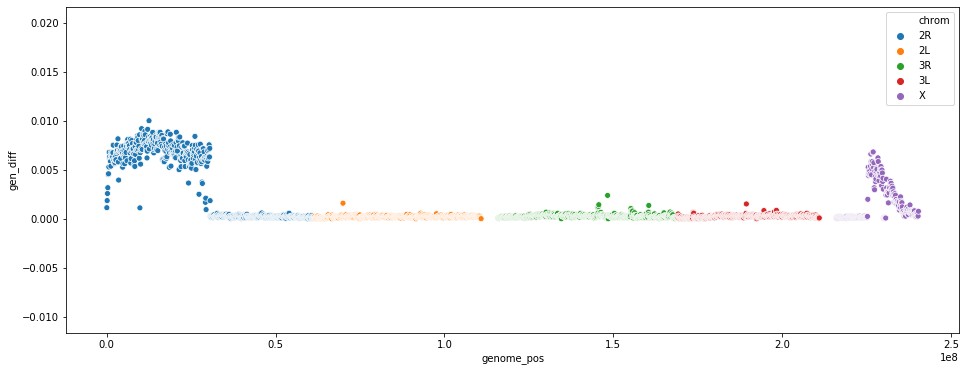

In [16]:
plt.rcParams["figure.figsize"] = (16, 6)
sns.scatterplot(x = pair1_table.genome_pos, y = pair1_table.gen_diff, hue = pair1_table.chrom)

(0.95, 1.001)

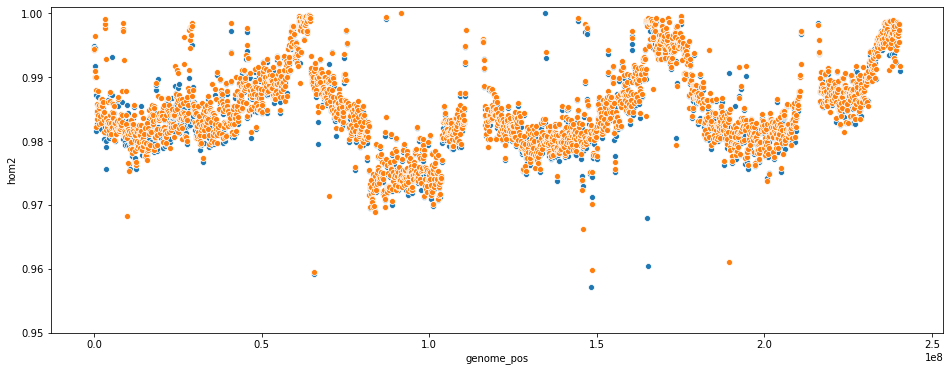

In [17]:
plt.rcParams["figure.figsize"] = (16, 6)
sns.scatterplot(x = pair1_table.genome_pos, y = pair1_table.hom1)
sns.scatterplot(x = pair1_table.genome_pos, y = pair1_table.hom2)
plt.ylim(0.95, 1.001)

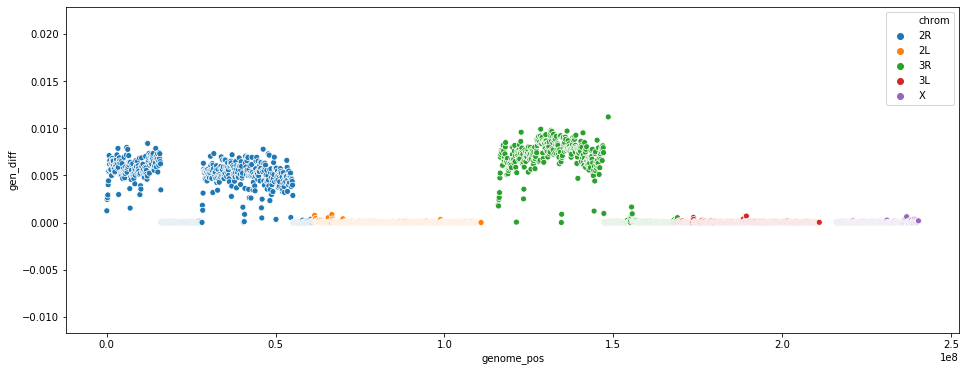

In [18]:
for chrom in pair2.keys():
    pair2[chrom]['chrom'] = chrom
    pair2[chrom]['genome_pos'] = pair2[chrom].index * window_size + chrom_starts[chrom]
    
pair2_table = pd.concat(list(pair2.values()))
plt.rcParams["figure.figsize"] = (16, 6)
sns.scatterplot(x = pair2_table.genome_pos, y = pair2_table.gen_diff, hue = pair2_table.chrom)

(0.95, 1.001)

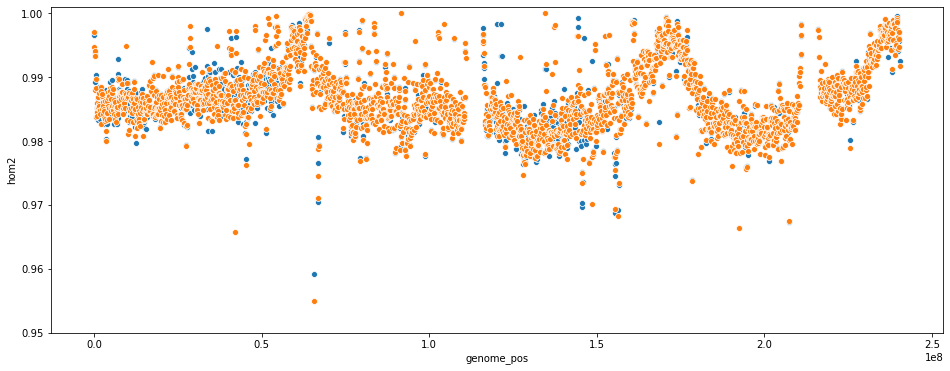

In [19]:
plt.rcParams["figure.figsize"] = (16, 6)
sns.scatterplot(x = pair2_table.genome_pos, y = pair2_table.hom1)
sns.scatterplot(x = pair2_table.genome_pos, y = pair2_table.hom2)
plt.ylim(0.95, 1.001)

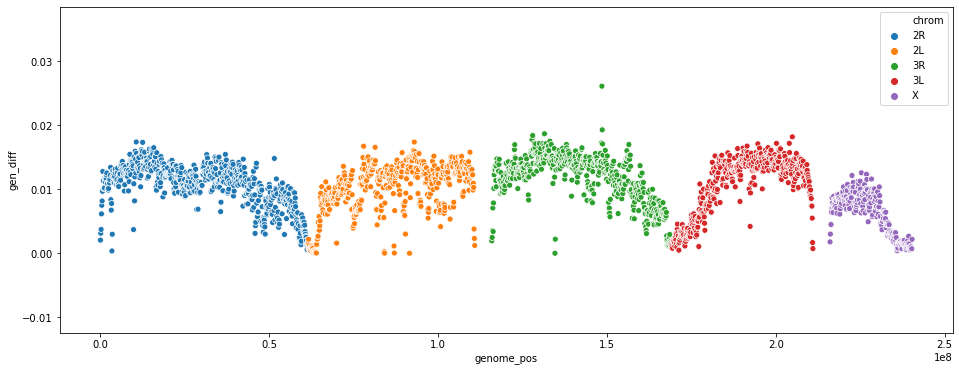

In [20]:
for chrom in pair3.keys():
    pair3[chrom]['chrom'] = chrom
    pair3[chrom]['genome_pos'] = pair3[chrom].index * window_size + chrom_starts[chrom]
    
pair3_table = pd.concat(list(pair3.values()))
plt.rcParams["figure.figsize"] = (16, 6)
sns.scatterplot(x = pair3_table.genome_pos, y = pair3_table.gen_diff, hue = pair3_table.chrom)

(0.95, 1.001)

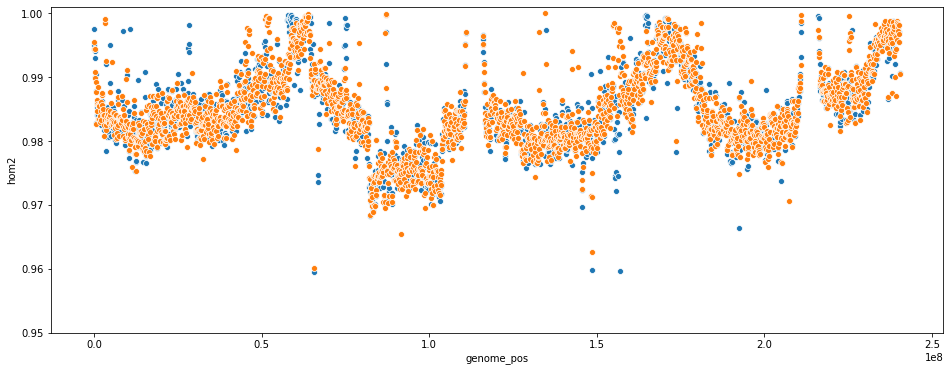

In [21]:
plt.rcParams["figure.figsize"] = (16, 6)
sns.scatterplot(x = pair3_table.genome_pos, y = pair3_table.hom1)
sns.scatterplot(x = pair3_table.genome_pos, y = pair3_table.hom2)
plt.ylim(0.95, 1.001)